In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
# 計算組合績效：期望回報和風險
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (returns - risk_free_rate) / std
    return returns, std, sharpe_ratio

In [3]:
# 最小化風險以找到給定回報的最佳組合
def minimize_volatility(weights, mean_returns, cov_matrix, target_return):
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))
    result = minimize(lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1], weights,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [4]:
# 找到最大夏普比率的組合
def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.02):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(lambda x: -portfolio_performance(x, mean_returns, cov_matrix, risk_free_rate)[2],
                      num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [5]:
# 繪製效率前緣
def efficient_frontier(mean_returns, cov_matrix, num_portfolios=100, risk_free_rate=0.02):
    results = {'returns': [], 'volatility': [], 'sharpe_ratios': []}
    weights = np.array([1 / len(mean_returns)] * len(mean_returns))
    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), num_portfolios)

    for target_return in target_returns:
        optimized_result = minimize_volatility(weights, mean_returns, cov_matrix, target_return)
        if optimized_result.success:
            ret, vol, sharpe = portfolio_performance(optimized_result.x, mean_returns, cov_matrix, risk_free_rate)
            results['returns'].append(ret)
            results['volatility'].append(vol)
            results['sharpe_ratios'].append(sharpe)
    # 找到最大夏普比率的組合
    max_sharpe_result = maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    max_sharpe_ret, max_sharpe_vol, _ = portfolio_performance(max_sharpe_result.x, mean_returns, cov_matrix, risk_free_rate)

    # 繪製效率前緣
    plt.figure(figsize=(10, 6))
    plt.scatter(results['volatility'], results['returns'], c=results['sharpe_ratios'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_vol, max_sharpe_ret, marker='*', color='r', s=200, label='Maximum Sharpe Ratio')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier with Sharpe Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
# 使用滾動視窗計算效率前緣並繪製代表圖形
def rolling_efficient_frontier(stock_symbols, window=120, start_date='2017-01-01', end_date='2023-01-01'):
    # 1. 下載所有股票數據並計算日回報率
    data = pd.DataFrame()
    for symbol in stock_symbols:
        stock_data = yf.download(symbol, start=start_date, end=end_date)['Adj Close'].pct_change().dropna()
        data[symbol] = stock_data

    # 2. 滾動計算效率前緣並繪製一張代表圖形
    rolling_windows = data.rolling(window=window)
    mean_returns_list = []
    cov_matrix_list = []
    for i in range(window, len(data)):
        rolling_data = data.iloc[i - window:i]
        mean_returns = rolling_data.mean()
        cov_matrix = rolling_data.cov()
        mean_returns_list.append(mean_returns)
        cov_matrix_list.append(cov_matrix)

    # 使用最後一個滾動視窗的結果繪製效率前緣，並顯示最大夏普比率時各支股票的權重
    if mean_returns_list and cov_matrix_list:
        mean_returns = mean_returns_list[-1]
        cov_matrix = cov_matrix_list[-1]
        max_sharpe_result = maximize_sharpe_ratio(mean_returns, cov_matrix)
        max_sharpe_weights = max_sharpe_result.x
        print("最大夏普比率時各支股票的權重:")
        for symbol, weight in zip(stock_symbols, max_sharpe_weights):
            print(f"{symbol}: {weight:.4f}")
        efficient_frontier(mean_returns, cov_matrix)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


最大夏普比率時各支股票的權重:
2330.TW: 0.0000
2317.TW: 0.0000
2603.TW: 1.0000


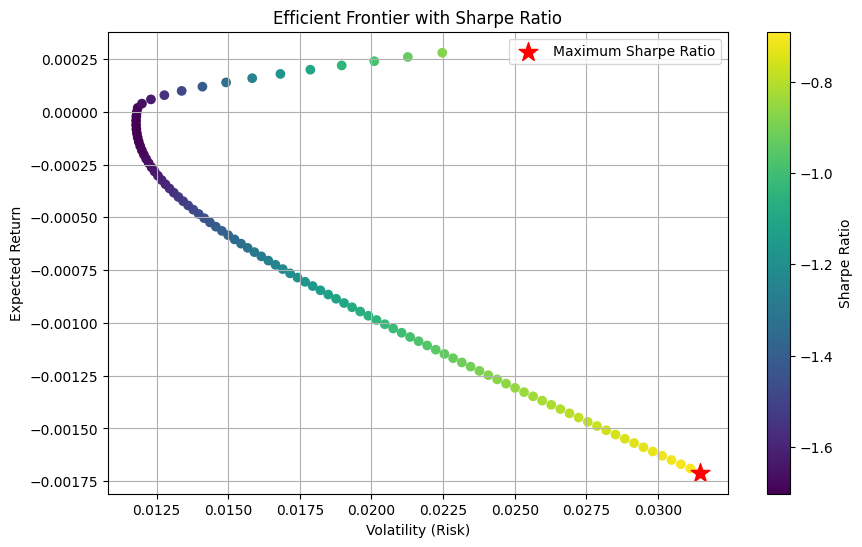

In [7]:
# 計算並繪製效率前緣
rolling_efficient_frontier(['2330.TW', '2317.TW', '2603.TW'])